## Model buildiing
- Notebook used to validate feature selection for logistic regression 
- Find features
- Build model
- Check accuracy score
- Output pickle model 
- output empty datrame with dummy columns

In [169]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import numpy as np
from pybaseball import statcast

%matplotlib inline


### Data collection

In [174]:
inital_data = statcast(start_dt='2020-07-23', end_dt='2020-9-27')

This is a large query, it may take a moment to complete
Completed sub-query from 2020-07-23 to 2020-07-28
Completed sub-query from 2020-07-29 to 2020-08-03
Completed sub-query from 2020-08-04 to 2020-08-09
Completed sub-query from 2020-08-10 to 2020-08-15
Completed sub-query from 2020-08-16 to 2020-08-21
Completed sub-query from 2020-08-22 to 2020-08-27
Completed sub-query from 2020-08-28 to 2020-09-02
Completed sub-query from 2020-09-03 to 2020-09-08
Completed sub-query from 2020-09-09 to 2020-09-14
Completed sub-query from 2020-09-15 to 2020-09-20
Completed sub-query from 2020-09-21 to 2020-09-26
Completed sub-query from 2020-09-27 to 2020-9-27


In [175]:
inital_data.head()

,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
0,615,FF,2020-09-27,91.6,2.31,6.19,Brad Hand,605137.0,543272.0,field_out,hit_into_play,NaN,NaN,NaN,NaN,1.0,Josh Bell flies out to right fielder Jordan Lu...,R,R,L,CLE,PIT,X,9.0,fly_ball,1.0,0.0,2020.0,0.9,1.3,-0.30,3.31,NaN,NaN,NaN,2.0,9.0,Top,217.94,101.96,NaN,NaN,547379.0,NaN,NaN,-8.326379,-133.205861,-4.261343,11.890496,25.776284,-15.718337,3.73,1.77,315.0,88.4,32.0,90.8,2524.0,5.6,631538.0,543272.0,547379.0,467793.0,514917.0,608070.0,596019.0,640458.0,592261.0,656669.0,54.90,0.043,0.049,0.0,1.0,0.0,0.0,3.0,77.0,2.0,4-Seam Fastball,8.0,6.0,6.0,8.0,6.0,8.0,6.0,8.0,Standard,Standard
1,635,SL,2020-09-27,80.4,2.45,6.12,Brad Hand,605137.0,543272.0,NaN,ball,NaN,NaN,NaN,NaN,13.0,NaN,R,R,L,CLE,PIT,B,NaN,NaN,0.0,0.0,2020.0,-1.1,0.0,-0.86,1.31,NaN,NaN,NaN,2.0,9.0,Top,NaN,NaN,NaN,NaN,547379.0,NaN,NaN,-5.260466,-116.999311,-3.880876,-8.699110,21.709584,-31.961590,3.86,1.91,NaN,NaN,NaN,79.2,2527.0,5.4,631538.0,543272.0,547379.0,467793.0,514917.0,608070.0,596019.0,640458.0,592261.0,656669.0,55.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.0,1.0,Slider,8.0,6.0,6.0,8.0,6.0,8.0,6.0,8.0,Standard,Standard
2,638,SL,2020-09-27,80.8,2.27,6.09,Brad Hand,592567.0,543272.0,strikeout,swinging_strike,NaN,NaN,NaN,NaN,13.0,Colin Moran strikes out swinging.,R,L,L,CLE,PIT,S,2.0,NaN,0.0,2.0,2020.0,-1.4,-0.1,-1.90,1.26,NaN,NaN,NaN,1.0,9.0,Top,NaN,NaN,NaN,NaN,547379.0,NaN,NaN,-6.545887,-117.560799,-3.823399,-11.851736,21.561248,-33.038975,3.59,1.70,NaN,NaN,NaN,79.9,2357.0,5.6,631538.0,543272.0,547379.0,467793.0,514917.0,608070.0,596019.0,640458.0,592261.0,656669.0,54.93,NaN,NaN,0.0,1.0,0.0,0.0,NaN,76.0,4.0,Slider,8.0,6.0,6.0,8.0,6.0,8.0,6.0,8.0,Infield shift,Standard
3,658,SL,2020-09-27,80.5,2.41,6.12,Brad Hand,592567.0,543272.0,NaN,foul,NaN,NaN,NaN,NaN,13.0,NaN,R,L,L,CLE,PIT,S,NaN,NaN,0.0,2.0,2020.0,-1.7,0.0,-0.90,1.80,NaN,NaN,NaN,1.0,9.0,Top,NaN,NaN,NaN,NaN,547379.0,NaN,NaN,-4.073822,-117.239671,-2.937641,-14.751489,23.216014,-31.542664,3.59,1.70,NaN,NaN,NaN,79.1,2405.0,5.3,631538.0,543272.0,547379.0,467793.0,514917.0,608070.0,596019.0,640458.0,592261.0,656669.0,55.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.0,3.0,Slider,8.0,6.0,6.0,8.0,6.0,8.0,6.0,8.0,Infield shift,Standard
4,662,SL,2020-09-27,81.4,2.35,6.14,Brad Hand,592567.0,543272.0,NaN,swinging_strike,NaN,NaN,NaN,NaN,13.0,NaN,R,L,L,CLE,PIT,S,NaN,NaN,0.0,1.0,2020.0,-1.7,0.0,-0.98,2.25,NaN,NaN,NaN,1.0,9.0,Top,NaN,NaN,NaN,NaN,547379.0,NaN,NaN,-4.216575,-118.535362,-2.219346,-14.860351,22.417236,-31.546104,3.59,1.70,NaN,NaN,NaN,80.3,2482.0,5.4,631538.0,543272.0,547379.0,467793.0,514917.0,608070.0,596019.0,640458.0,592261.0,656669.0,55.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.0,2.0,Slider,8.0,6.0,6.0,8.0,6.0,8.0,6.0,8.0,Infield shift,Standard


In [176]:
inital_data.drop(columns="index", inplace=True)

In [177]:
inital_data.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
0,FF,2020-09-27,91.6,2.31,6.19,Brad Hand,605137.0,543272.0,field_out,hit_into_play,NaN,NaN,NaN,NaN,1.0,Josh Bell flies out to right fielder Jordan Lu...,R,R,L,CLE,PIT,X,9.0,fly_ball,1.0,0.0,2020.0,0.9,1.3,-0.30,3.31,NaN,NaN,NaN,2.0,9.0,Top,217.94,101.96,NaN,NaN,547379.0,NaN,NaN,-8.326379,-133.205861,-4.261343,11.890496,25.776284,-15.718337,3.73,1.77,315.0,88.4,32.0,90.8,2524.0,5.6,631538.0,543272.0,547379.0,467793.0,514917.0,608070.0,596019.0,640458.0,592261.0,656669.0,54.90,0.043,0.049,0.0,1.0,0.0,0.0,3.0,77.0,2.0,4-Seam Fastball,8.0,6.0,6.0,8.0,6.0,8.0,6.0,8.0,Standard,Standard
1,SL,2020-09-27,80.4,2.45,6.12,Brad Hand,605137.0,543272.0,NaN,ball,NaN,NaN,NaN,NaN,13.0,NaN,R,R,L,CLE,PIT,B,NaN,NaN,0.0,0.0,2020.0,-1.1,0.0,-0.86,1.31,NaN,NaN,NaN,2.0,9.0,Top,NaN,NaN,NaN,NaN,547379.0,NaN,NaN,-5.260466,-116.999311,-3.880876,-8.699110,21.709584,-31.961590,3.86,1.91,NaN,NaN,NaN,79.2,2527.0,5.4,631538.0,543272.0,547379.0,467793.0,514917.0,608070.0,596019.0,640458.0,592261.0,656669.0,55.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.0,1.0,Slider,8.0,6.0,6.0,8.0,6.0,8.0,6.0,8.0,Standard,Standard
2,SL,2020-09-27,80.8,2.27,6.09,Brad Hand,592567.0,543272.0,strikeout,swinging_strike,NaN,NaN,NaN,NaN,13.0,Colin Moran strikes out swinging.,R,L,L,CLE,PIT,S,2.0,NaN,0.0,2.0,2020.0,-1.4,-0.1,-1.90,1.26,NaN,NaN,NaN,1.0,9.0,Top,NaN,NaN,NaN,NaN,547379.0,NaN,NaN,-6.545887,-117.560799,-3.823399,-11.851736,21.561248,-33.038975,3.59,1.70,NaN,NaN,NaN,79.9,2357.0,5.6,631538.0,543272.0,547379.0,467793.0,514917.0,608070.0,596019.0,640458.0,592261.0,656669.0,54.93,NaN,NaN,0.0,1.0,0.0,0.0,NaN,76.0,4.0,Slider,8.0,6.0,6.0,8.0,6.0,8.0,6.0,8.0,Infield shift,Standard
3,SL,2020-09-27,80.5,2.41,6.12,Brad Hand,592567.0,543272.0,NaN,foul,NaN,NaN,NaN,NaN,13.0,NaN,R,L,L,CLE,PIT,S,NaN,NaN,0.0,2.0,2020.0,-1.7,0.0,-0.90,1.80,NaN,NaN,NaN,1.0,9.0,Top,NaN,NaN,NaN,NaN,547379.0,NaN,NaN,-4.073822,-117.239671,-2.937641,-14.751489,23.216014,-31.542664,3.59,1.70,NaN,NaN,NaN,79.1,2405.0,5.3,631538.0,543272.0,547379.0,467793.0,514917.0,608070.0,596019.0,640458.0,592261.0,656669.0,55.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.0,3.0,Slider,8.0,6.0,6.0,8.0,6.0,8.0,6.0,8.0,Infield shift,Standard
4,SL,2020-09-27,81.4,2.35,6.14,Brad Hand,592567.0,543272.0,NaN,swinging_strike,NaN,NaN,NaN,NaN,13.0,NaN,R,L,L,CLE,PIT,S,NaN,NaN,0.0,1.0,2020.0,-1.7,0.0,-0.98,2.25,NaN,NaN,NaN,1.0,9.0,Top,NaN,NaN,NaN,NaN,547379.0,NaN,NaN,-4.216575,-118.535362,-2.219346,-14.860351,22.417236,-31.546104,3.59,1.70,NaN,NaN,NaN,80.3,2482.0,5.4,631538.0,543272.0,547379.0,467793.0,514917.0,608070.0,596019.0,640458.0,592261.0,656669.0,55.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.0,2.0,Slider,8.0,6.0,6.0,8.0,6.0,8.0,6.0,8.0,Infield shift,Standard


In [ ]:
inital_data.to_csv('../backend/mapping_heat/fixtures/pitching_data.csv')

#### Import dataset

In [ ]:
df = pd.read_csv('../backend/mapping_heat/fixtures/pitching_data.csv')

In [162]:
df.columns

Index(['index', 'pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
     

In [163]:
pd.set_option('display.max_columns', None)
df.head()

,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
0,613,FF,9/27/20,91.6,2.31,6.19,Brad Hand,605137,543272,field_out,hit_into_play,NaN,NaN,NaN,NaN,1.0,Josh Bell flies out to right fielder Jordan Lu...,R,R,L,CLE,PIT,X,9.0,fly_ball,1,0,2020,0.9,1.3,-0.30,3.31,NaN,NaN,NaN,2,9,Top,217.94,101.96,NaN,NaN,547379,NaN,NaN,-8.326379,-133.205861,-4.261343,11.890496,25.776284,-15.718337,3.73,1.77,315.0,88.4,32.0,90.8,2524.0,5.6,631538,543272,547379,467793,514917,608070,596019,640458,592261,656669,54.90,0.043,0.049,0.0,1.0,0.0,0.0,3.0,77,2,4-Seam Fastball,8,6,6,8,6,8,6,8,Standard,Standard
1,635,SL,9/27/20,80.4,2.45,6.12,Brad Hand,605137,543272,NaN,ball,NaN,NaN,NaN,NaN,13.0,NaN,R,R,L,CLE,PIT,B,NaN,NaN,0,0,2020,-1.1,0.0,-0.86,1.31,NaN,NaN,NaN,2,9,Top,NaN,NaN,NaN,NaN,547379,NaN,NaN,-5.260466,-116.999311,-3.880876,-8.699110,21.709584,-31.961590,3.86,1.91,NaN,NaN,NaN,79.2,2527.0,5.4,631538,543272,547379,467793,514917,608070,596019,640458,592261,656669,55.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77,1,Slider,8,6,6,8,6,8,6,8,Standard,Standard
2,637,SL,9/27/20,80.8,2.27,6.09,Brad Hand,592567,543272,strikeout,swinging_strike,NaN,NaN,NaN,NaN,13.0,Colin Moran strikes out swinging.,R,L,L,CLE,PIT,S,2.0,NaN,0,2,2020,-1.4,-0.1,-1.90,1.26,NaN,NaN,NaN,1,9,Top,NaN,NaN,NaN,NaN,547379,NaN,NaN,-6.545887,-117.560799,-3.823399,-11.851736,21.561248,-33.038975,3.59,1.70,NaN,NaN,NaN,79.9,2357.0,5.6,631538,543272,547379,467793,514917,608070,596019,640458,592261,656669,54.93,NaN,NaN,0.0,1.0,0.0,0.0,NaN,76,4,Slider,8,6,6,8,6,8,6,8,Infield shift,Standard
3,660,SL,9/27/20,80.5,2.41,6.12,Brad Hand,592567,543272,NaN,foul,NaN,NaN,NaN,NaN,13.0,NaN,R,L,L,CLE,PIT,S,NaN,NaN,0,2,2020,-1.7,0.0,-0.90,1.80,NaN,NaN,NaN,1,9,Top,NaN,NaN,NaN,NaN,547379,NaN,NaN,-4.073822,-117.239671,-2.937641,-14.751489,23.216014,-31.542665,3.59,1.70,NaN,NaN,NaN,79.1,2405.0,5.3,631538,543272,547379,467793,514917,608070,596019,640458,592261,656669,55.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76,3,Slider,8,6,6,8,6,8,6,8,Infield shift,Standard
4,661,SL,9/27/20,81.4,2.35,6.14,Brad Hand,592567,543272,NaN,swinging_strike,NaN,NaN,NaN,NaN,13.0,NaN,R,L,L,CLE,PIT,S,NaN,NaN,0,1,2020,-1.7,0.0,-0.98,2.25,NaN,NaN,NaN,1,9,Top,NaN,NaN,NaN,NaN,547379,NaN,NaN,-4.216575,-118.535362,-2.219346,-14.860351,22.417236,-31.546104,3.59,1.70,NaN,NaN,NaN,80.3,2482.0,5.4,631538,543272,547379,467793,514917,608070,596019,640458,592261,656669,55.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76,2,Slider,8,6,6,8,6,8,6,8,Infield shift,Standard


In [164]:
df.shape

(263584, 90)

### Find features to use for model

#### Pitchers

In [ ]:
pitcheres = df.player_name.value_counts().to_frame().reset_index().rename(columns={'index': 'pitcher', 'player_name': 'count'})
pitcheres.head()

In [7]:
pitcheres['count'].mean()

359.5961800818554

In [8]:
pitcheres['count'].min()

2

In [9]:
pitcheres['count'].describe()

count     733.000000
mean      359.596180
std       299.813281
min         2.000000
25%       118.000000
50%       302.000000
75%       470.000000
max      1408.000000
Name: count, dtype: float64

In [10]:
df.player_name.value_counts().to_frame().mean()

player_name    359.59618
dtype: float64

#### Release speed

In [11]:
df.release_speed.value_counts().head(10)

93.5    2154
93.9    2142
93.1    2142
93.3    2128
93.4    2123
93.8    2120
93.2    2113
94.1    2109
92.7    2100
92.9    2096
Name: release_speed, dtype: int64

In [12]:
rl_speed = df.release_speed.value_counts().to_frame().reset_index().rename(columns={'index': 'speed', 'release_speed': 'count'})

In [13]:
rl_speed.speed.describe()

count    466.000000
mean      77.944635
std       14.872838
min       38.100000
25%       67.125000
50%       78.750000
75%       90.375000
max      102.200000
Name: speed, dtype: float64

In [14]:
rl_speed.loc[rl_speed.speed.isnull()]

,speed,count


#### Pitch outcome

In [15]:
df.type.value_counts()

S    121964
B     97648
X     43972
Name: type, dtype: int64

In [195]:
(df.type.value_counts().to_frame().loc['S'][0] / df.type.value_counts().to_frame()['type'].sum()) * 100

46.27139735340536

In [192]:
df.type.value_counts().to_frame().loc['S'][0]

121964

In [203]:
(df.type.value_counts().to_frame().loc['B'][0] / df.type.value_counts().to_frame()['type'].sum()) * 100

37.04625470438266

#### Outcome per at bat

In [16]:
df.events.value_counts()

field_out                     25530
strikeout                     15543
single                         9071
walk                           5890
double                         2823
home_run                       2304
force_out                      1308
grounded_into_double_play      1235
hit_by_pitch                    821
field_error                     513
sac_fly                         399
triple                          241
double_play                     150
fielders_choice                 149
sac_bunt                        126
fielders_choice_out             118
caught_stealing_2b               71
strikeout_double_play            43
interf_def                       35
pickoff_caught_stealing_2b       14
pickoff_1b                       12
other_out                        11
pickoff_2b                        7
caught_stealing_3b                6
caught_stealing_home              4
sac_fly_double_play               3
triple_play                       2
pickoff_caught_stealing_3b  

#### Description per pitch outcome

In [17]:
df.description.value_counts()

ball                       89937
foul                       44716
called_strike              44320
hit_into_play              28264
swinging_strike            28026
hit_into_play_no_out        9685
blocked_ball                6874
hit_into_play_score         6029
foul_tip                    2427
swinging_strike_blocked     1968
hit_by_pitch                 821
foul_bunt                    434
missed_bunt                   62
pitchout                      16
bunt_foul_tip                  5
Name: description, dtype: int64

###### Pitch zones

In [18]:
df.zone

0          1.0
1         13.0
2         13.0
3         13.0
4         13.0
          ... 
263579     5.0
263580     7.0
263581     9.0
263582    11.0
263583    11.0
Name: zone, Length: 263584, dtype: float64

In [19]:
df[df.zone.isnull()][['description']]

,description
20677,ball
20682,ball
70022,hit_into_play
70023,blocked_ball
70024,called_strike
...,...
233601,foul
233738,foul
234935,ball
234937,ball


In [20]:
df.pitch_type.value_counts()

FF    89618
SL    46849
SI    42768
CH    31131
CU    24679
FC    17404
KC     5939
FS     4528
CS      191
KN       23
FO        3
Name: pitch_type, dtype: int64

##### Pitch legend

- AB Automatic Ball
- AS Automatic Strike
- CH Change-​up
- CU Curveball
- EP Eephus
- FC Cutter
- FF Four-Seam Fastball
- FO Forkball
- FS Splitter
- FT Two-Seam Fastball (synonymous with SI)
- GY Gyroball
- IN Intentional Ball
- KC Knuckle Curve
- KN Knuckleball
- NP No Pitch
- PO Pitchout
- SC Screwball
- SI Sinker (synonymous with FT)
- SL Slider
- UN Unknown

In [21]:
df.groupby(['pitch_type', 'pitch_name']).size().to_frame().reset_index().rename(columns={0: 'count'}).sort_values(by='count', ascending=False)

,pitch_type,pitch_name,count
4,FF,4-Seam Fastball,89618
10,SL,Slider,46849
9,SI,Sinker,42768
0,CH,Changeup,31131
2,CU,Curveball,24679
3,FC,Cutter,17404
7,KC,Knuckle Curve,5939
6,FS,Split-Finger,4528
1,CS,Curveball,191
8,KN,Knuckleball,23


In [22]:
# x = df[~df.zone.isnull() & ~df.release_spin_rate.isnull()].copy()
x = df[~df.zone.isnull()].copy()

In [23]:
x.shape

(263393, 90)

##### Hot encode non numeric values for y values

In [24]:
def hot_encode_des(x):
    if x == 'hit_into_play_no_out' or x == 'hit_into_play_score':
        return 1
    return 0

In [25]:
def hot_encode_event(x):
    if x == 'single' or x == 'double' or x == 'triple' or x == 'home_run':
        return 1
    return 0

In [26]:
x['norm_zone'] = x['zone'].astype(str)

### Selected features

In [27]:
x_norm = x[['player_name', 'pitch_type', 'release_speed', 'norm_zone']]
# x_norm = x[['release_spin_rate', 'pitch_type', 'release_speed', 'norm_zone']]
# x_norm = x[[ 'pitch_type',  'norm_zone']]


In [28]:
# x_norm[x_norm.release_speed.isnull()]

In [29]:
y = x['description'].apply(lambda x: hot_encode_des(x))

##### Hot encode non numeric data

In [30]:
x = pd.get_dummies(x_norm)

##### Look at y values

In [31]:
hits = [i for i in y if i == 1]
print(len(hits))
print(len(y))
print((len(hits)/len(y) )* 100) 

15706
263393
5.962952698059554


##### Split data

In [32]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30)

##### view train data

In [33]:
X_train.head()

,release_speed,player_name_A.J. Cole,player_name_A.J. Minter,player_name_AJ Ramos,player_name_Aaron Barrett,player_name_Aaron Bummer,player_name_Aaron Civale,player_name_Aaron Fletcher,player_name_Aaron Loup,player_name_Aaron Nola,player_name_Aaron Slegers,player_name_Adam Cimber,player_name_Adam Kolarek,player_name_Adam Morgan,player_name_Adam Ottavino,player_name_Adam Plutko,player_name_Adam Wainwright,player_name_Adbert Alzolay,player_name_Adonis Medina,player_name_Adrian Houser,player_name_Adrian Morejon,player_name_Albert Abreu,player_name_Alec Mills,player_name_Alex Claudio,player_name_Alex Cobb,player_name_Alex Colome,player_name_Alex McRae,player_name_Alex Reyes,player_name_Alex Vesia,player_name_Alex Wood,player_name_Alex Young,player_name_Amir Garrett,player_name_Andre Scrubb,player_name_Andrew Chafin,player_name_Andrew Heaney,player_name_Andrew Kittredge,player_name_Andrew Miller,player_name_Andrew Suarez,player_name_Andrew Triggs,player_name_Angel Perdomo,player_name_Anibal Sanchez,player_name_Anthony Banda,player_name_Anthony Bass,player_name_Anthony Bemboom,player_name_Anthony Castro,player_name_Anthony DeSclafani,player_name_Anthony Kay,player_name_Anthony Misiewicz,player_name_Antonio Santos,player_name_Antonio Senzatela,player_name_Archie Bradley,player_name_Ariel Jurado,player_name_Aroldis Chapman,player_name_Artie Lewicki,player_name_Asher Wojciechowski,player_name_Ashton Goudeau,player_name_Austin Adams,player_name_Austin Brice,player_name_Austin Davis,player_name_Austin Gomber,player_name_Austin Voth,player_name_Beau Burrows,player_name_Ben Braymer,player_name_Ben Heller,player_name_Bernardo Flores Jr.,player_name_Blake Cederlind,player_name_Blake Parker,player_name_Blake Snell,player_name_Blake Taylor,player_name_Blake Treinen,player_name_Bobby Wahl,player_name_Brad Boxberger,player_name_Brad Brach,player_name_Brad Hand,player_name_Brad Keller,player_name_Brad Peacock,player_name_Brad Wieck,player_name_Brady Lail,player_name_Brady Singer,player_name_Brailyn Marquez,player_name_Branden Kline,player_name_Brandon Bailey,player_name_Brandon Bielak,player_name_Brandon Brennan,player_name_Brandon Kintzler,player_name_Brandon Leibrandt,player_name_Brandon Waddell,player_name_Brandon Woodruff,player_name_Brandon Workman,player_name_Braxton Garrett,player_name_Brent Suter,player_name_Brett Anderson,player_name_Brett Eibner,player_name_Brett Martin,player_name_Brian Moran,player_name_Brock Holt,player_name_Brooks Kriske,player_name_Brooks Raley,player_name_Bruce Zimmermann,player_name_Brusdar Graterol,player_name_Bryan Abreu,player_name_Bryan Garcia,player_name_Bryan Holaday,player_name_Bryan Shaw,player_name_Bryse Wilson,player_name_Buck Farmer,player_name_Burch Smith,player_name_Cal Quantrill,player_name_Caleb Baragar,player_name_Caleb Ferguson,player_name_Caleb Smith,player_name_Caleb Thielbar,player_name_Cam Bedrosian,player_name_Cam Hill,player_name_Carl Edwards Jr.,player_name_Carlos Carrasco,player_name_Carlos Estevez,player_name_Carlos Hernandez,player_name_Carlos Martinez,player_name_Carlos Rodon,player_name_Carlos Sanabria,player_name_Carson Fulmer,player_name_Carson Kelly,player_name_Casey Mize,player_name_Casey Sadler,player_name_Cesar Valdez,player_name_Chad Green,player_name_Chad Kuhl,player_name_Chad Sobotka,player_name_Chance Adams,player_name_Charlie Culberson,player_name_Charlie Morton,player_name_Chase Anderson,player_name_Chase De Jong,player_name_Chasen Shreve,player_name_Chaz Roe,player_name_Chi Chi Gonzalez,player_name_Chris Bassitt,player_name_Chris Devenski,player_name_Chris Martin,player_name_Chris Mazza,player_name_Chris Paddack,player_name_Chris Rusin,player_name_Chris Stratton,player_name_Cionel Perez,player_name_Clarke Schmidt,player_name_Clay Holmes,player_name_Clayton Kershaw,player_name_Codi Heuer,player_name_Cody Carroll,player_name_Cody Ponce,player_name_Cody Reed,player_name_Cody Stashak,player_name_Cole Hamels,player_name_Cole Irvin,player_name_Cole Sulser,player_name_Colin Rea,

##### View shape

In [34]:
X_train.shape

(184375, 758)

In [35]:
X_test.head()

,release_speed,player_name_A.J. Cole,player_name_A.J. Minter,player_name_AJ Ramos,player_name_Aaron Barrett,player_name_Aaron Bummer,player_name_Aaron Civale,player_name_Aaron Fletcher,player_name_Aaron Loup,player_name_Aaron Nola,player_name_Aaron Slegers,player_name_Adam Cimber,player_name_Adam Kolarek,player_name_Adam Morgan,player_name_Adam Ottavino,player_name_Adam Plutko,player_name_Adam Wainwright,player_name_Adbert Alzolay,player_name_Adonis Medina,player_name_Adrian Houser,player_name_Adrian Morejon,player_name_Albert Abreu,player_name_Alec Mills,player_name_Alex Claudio,player_name_Alex Cobb,player_name_Alex Colome,player_name_Alex McRae,player_name_Alex Reyes,player_name_Alex Vesia,player_name_Alex Wood,player_name_Alex Young,player_name_Amir Garrett,player_name_Andre Scrubb,player_name_Andrew Chafin,player_name_Andrew Heaney,player_name_Andrew Kittredge,player_name_Andrew Miller,player_name_Andrew Suarez,player_name_Andrew Triggs,player_name_Angel Perdomo,player_name_Anibal Sanchez,player_name_Anthony Banda,player_name_Anthony Bass,player_name_Anthony Bemboom,player_name_Anthony Castro,player_name_Anthony DeSclafani,player_name_Anthony Kay,player_name_Anthony Misiewicz,player_name_Antonio Santos,player_name_Antonio Senzatela,player_name_Archie Bradley,player_name_Ariel Jurado,player_name_Aroldis Chapman,player_name_Artie Lewicki,player_name_Asher Wojciechowski,player_name_Ashton Goudeau,player_name_Austin Adams,player_name_Austin Brice,player_name_Austin Davis,player_name_Austin Gomber,player_name_Austin Voth,player_name_Beau Burrows,player_name_Ben Braymer,player_name_Ben Heller,player_name_Bernardo Flores Jr.,player_name_Blake Cederlind,player_name_Blake Parker,player_name_Blake Snell,player_name_Blake Taylor,player_name_Blake Treinen,player_name_Bobby Wahl,player_name_Brad Boxberger,player_name_Brad Brach,player_name_Brad Hand,player_name_Brad Keller,player_name_Brad Peacock,player_name_Brad Wieck,player_name_Brady Lail,player_name_Brady Singer,player_name_Brailyn Marquez,player_name_Branden Kline,player_name_Brandon Bailey,player_name_Brandon Bielak,player_name_Brandon Brennan,player_name_Brandon Kintzler,player_name_Brandon Leibrandt,player_name_Brandon Waddell,player_name_Brandon Woodruff,player_name_Brandon Workman,player_name_Braxton Garrett,player_name_Brent Suter,player_name_Brett Anderson,player_name_Brett Eibner,player_name_Brett Martin,player_name_Brian Moran,player_name_Brock Holt,player_name_Brooks Kriske,player_name_Brooks Raley,player_name_Bruce Zimmermann,player_name_Brusdar Graterol,player_name_Bryan Abreu,player_name_Bryan Garcia,player_name_Bryan Holaday,player_name_Bryan Shaw,player_name_Bryse Wilson,player_name_Buck Farmer,player_name_Burch Smith,player_name_Cal Quantrill,player_name_Caleb Baragar,player_name_Caleb Ferguson,player_name_Caleb Smith,player_name_Caleb Thielbar,player_name_Cam Bedrosian,player_name_Cam Hill,player_name_Carl Edwards Jr.,player_name_Carlos Carrasco,player_name_Carlos Estevez,player_name_Carlos Hernandez,player_name_Carlos Martinez,player_name_Carlos Rodon,player_name_Carlos Sanabria,player_name_Carson Fulmer,player_name_Carson Kelly,player_name_Casey Mize,player_name_Casey Sadler,player_name_Cesar Valdez,player_name_Chad Green,player_name_Chad Kuhl,player_name_Chad Sobotka,player_name_Chance Adams,player_name_Charlie Culberson,player_name_Charlie Morton,player_name_Chase Anderson,player_name_Chase De Jong,player_name_Chasen Shreve,player_name_Chaz Roe,player_name_Chi Chi Gonzalez,player_name_Chris Bassitt,player_name_Chris Devenski,player_name_Chris Martin,player_name_Chris Mazza,player_name_Chris Paddack,player_name_Chris Rusin,player_name_Chris Stratton,player_name_Cionel Perez,player_name_Clarke Schmidt,player_name_Clay Holmes,player_name_Clayton Kershaw,player_name_Codi Heuer,player_name_Cody Carroll,player_name_Cody Ponce,player_name_Cody Reed,player_name_Cody Stashak,player_name_Cole Hamels,player_name_Cole Irvin,player_name_Cole Sulser,player_name_Colin Rea,

#### Build probability model

In [59]:
clf_train = LogisticRegression(max_iter=1000, solver='saga', penalty='elasticnet', l1_ratio=0.5)

In [60]:
clf_train.fit(X_train, y_train)

/Users/brandonl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.5, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [63]:
pred = clf_train.predict(X_test)

In [64]:
y_pred = pd.Series(clf_train.predict(X_test), index=y_test.index)

#### As expected, the classification is predicting all zeros (no hit).
- We don't really care about the classification since we want to find the probilities
- We'll use the classification to score the overall model
- We can then testt lowering P value for hit and see how it changes accuracy

In [65]:
pred

array([0, 0, 0, ..., 0, 0, 0])

In [66]:
for i in pred:
    if i == 1:
        print("hit")

##### Check accuracy score of model 

In [67]:
score = metrics.accuracy_score(y_test, pred)

In [68]:
score

0.9407982991217191

In [69]:
metrics.precision_score(y_pred, y_test, average='micro')

0.9407982991217191

In [70]:
metrics.f1_score(y_pred, y_test, average='weighted')

0.9694962114790229

In [71]:
cross_val_score(clf_train, x, y, cv=5) 

/Users/brandonl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/brandonl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/brandonl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/brandonl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/brandonl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarni

array([0.94037472, 0.94037472, 0.94035574, 0.94037359, 0.94037359])

###### describe the relationship between a predictor variable and the response. 

In [72]:
clf.coef_[0]

array([-1.02174557e-03,  0.00000000e+00, -4.07745753e-01,  0.00000000e+00,
        0.00000000e+00, -3.77305121e-01,  1.38542824e-01,  1.22159522e-02,
       -3.74307434e-01, -1.49866601e-01, -1.84553906e-01,  1.75564023e-01,
       -1.55408852e-01,  9.88707995e-02, -6.99205546e-02,  1.90166707e-01,
        5.30759633e-02, -3.56326736e-01, -1.73316576e-01,  2.07036001e-01,
        1.01630153e-01,  1.54698252e-01, -6.16538371e-02, -1.00990512e-01,
        2.82069586e-03, -2.81204877e-01, -8.26810149e-02, -2.08708598e-01,
       -3.73935176e-02,  8.47552473e-02,  1.64059132e-01, -2.97142797e-01,
       -2.84823447e-01,  0.00000000e+00, -1.74853504e-03, -2.57860528e-02,
       -1.39114274e-01, -5.17601523e-02, -1.22222930e-01,  0.00000000e+00,
        2.01093181e-01,  1.30680507e-01, -2.29733739e-01, -5.92164783e-02,
        0.00000000e+00,  2.69393860e-01,  1.30700170e-01, -2.53476199e-02,
        5.09711155e-01,  1.27424735e-01,  1.04694880e-01,  6.08238448e-01,
       -4.18467640e-01,  

(0, 1)

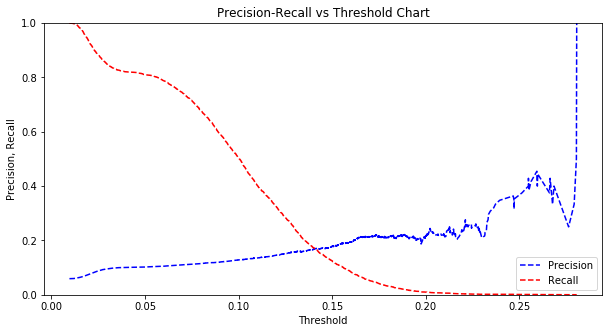

In [73]:
pred_y=clf.predict(X_test) 
probs_y=clf.predict_proba(X_test) 
precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 1])
pr_auc = metrics.auc(recall, precision)

plt.figure(figsize=(10,5))
plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="best")
plt.ylim([0,1])

Average precision-recall score: 0.13


Text(0.5, 1.0, 'Precision-Recall curve: AP=0.13')

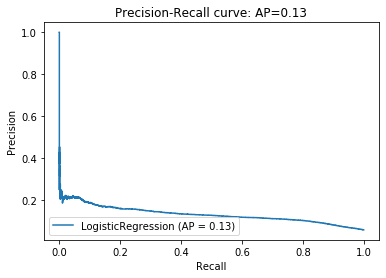

In [201]:
y_score = clf.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
disp = plot_precision_recall_curve(clf, X_test, y_test)
disp.ax_.set_title('Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [ ]:
sklearn.metrics.plot_precision_recall_curve()

In [143]:
pred_proba_df = pd.DataFrame(clf.predict_proba(X_test))
accuracy = {}
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = metrics.accuracy_score(y_test.to_numpy().reshape(y_test.to_numpy().size,1),
                                           y_test_pred.iloc[:,1].to_numpy().reshape(y_test_pred.iloc[:,1].to_numpy().size,1))
    print('Our testing accuracy is {}'.format(test_accuracy))
    accuracy[test_accuracy]  = i
    
    print(metrics.confusion_matrix(y_test.to_numpy().reshape(y_test.to_numpy().size,1),
                           y_test_pred.iloc[:,1].to_numpy().reshape(y_test_pred.iloc[:,1].to_numpy().size,1)))
    

scores = pd.DataFrame([accuracy2])



******** For i = 0.05 ******
Our testing accuracy is 0.5675921941836037
[[41060 33280]
 [  888  3790]]

******** For i = 0.1 ******
Our testing accuracy is 0.7682806449163482
[[58349 15991]
 [ 2319  2359]]

******** For i = 0.15 ******
Our testing accuracy is 0.9141587992609279
[[71653  2687]
 [ 4096   582]]

******** For i = 0.2 ******
Our testing accuracy is 0.9392163810777291
[[74169   171]
 [ 4632    46]]

******** For i = 0.25 ******
Our testing accuracy is 0.9407476777443115
[[74330    10]
 [ 4672     6]]

******** For i = 0.3 ******
Our testing accuracy is 0.9407982991217191
[[74340     0]
 [ 4678     0]]

******** For i = 0.35 ******
Our testing accuracy is 0.9407982991217191
[[74340     0]
 [ 4678     0]]

******** For i = 0.4 ******
Our testing accuracy is 0.9407982991217191
[[74340     0]
 [ 4678     0]]

******** For i = 0.45 ******
Our testing accuracy is 0.9407982991217191
[[74340     0]
 [ 4678     0]]

******** For i = 0.5 ******
Our testing accuracy is 0.9407982991217

In [202]:
score_val = scores2 * 100
s = score_val.T.reset_index().set_index(0)
s

,index
0,
5.0,0.567592
10.0,0.768281
15.0,0.914159
20.0,0.939216
25.0,0.940748
99.0,0.940798


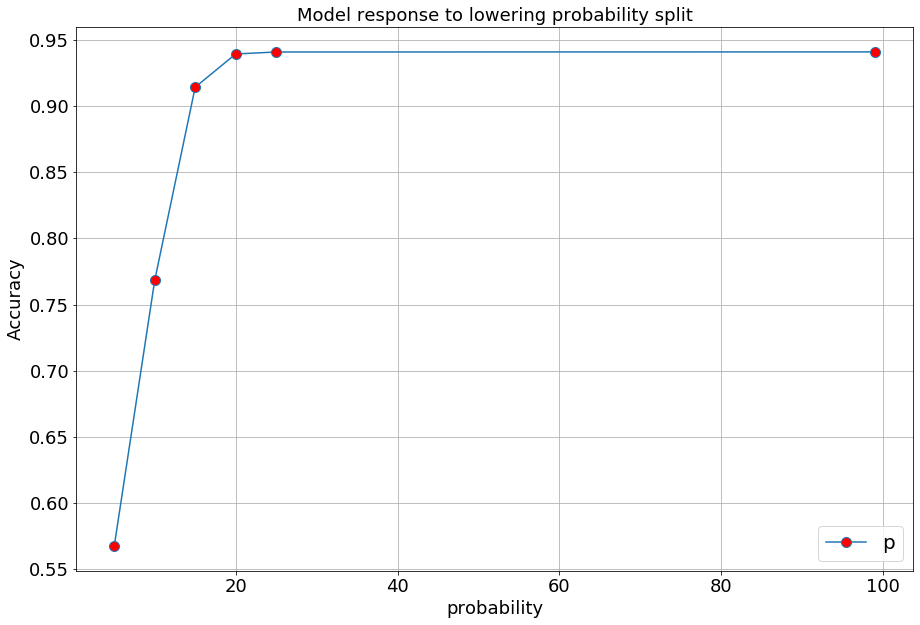

In [225]:
# plt.figure(figsize=(15,15))
s.plot(marker='o', markerfacecolor='red',  grid=True, markersize=10, figsize=(15,10), fontsize=18)
plt.legend(labels='probability', loc='lower right', prop={'size': 20})
plt.xlabel('probability', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.title('Model response to lowering probability split', fontsize=18);

###### Find the probs 

In [146]:
probs = clf.predict_proba(X=X_test)

In [147]:
probs = probs * 100

In [148]:
hit_prob = pd.DataFrame(probs, columns=['no-hit', 'hit'])

In [149]:
hit_prob.head()

,no-hit,hit
0,97.009752,2.990248
1,98.256551,1.743449
2,86.644079,13.355921
3,96.790267,3.209733
4,97.946769,2.053231


In [150]:
hit_prob.shape

(79018, 2)

###### Build out dataframe with probs and outcomes

In [151]:
x_df = X_test.copy()

In [152]:
y_df = pd.DataFrame(y_test)

In [153]:
y_df

,description
117369,0
249414,0
186342,0
202273,0
169551,0
...,...
225980,0
224872,0
160785,0
93441,0


In [154]:
x_df['description'] = y_df

In [155]:
x_df.head()[['release_speed', 'description' ]]

,release_speed,description
117369,84.9,0
249414,93.8,0
186342,90.1,0
202273,82.3,0
169551,72.2,0


In [156]:
x_df.reset_index(inplace=True)

In [204]:
final_df = x_df.join(hit_prob)

#### Basic probability stats

In [222]:
final_df.hit.describe()

count    79018.000000
mean         5.988901
std          4.670470
min          0.607302
25%          1.966629
50%          3.343504
75%          9.679457
max         28.069770
Name: hit, dtype: float64

In [220]:
final_df.hit.max()

28.069770322510646

In [213]:
final_df.hit.min()

0.6073018010339076

In [223]:
final_df['no-hit'].describe()

count    79018.000000
mean        94.011099
std          4.670470
min         71.930230
25%         90.320543
50%         96.656496
75%         98.033371
max         99.392698
Name: no-hit, dtype: float64

In [215]:
final_df['no-hit'].min()

71.93022967748935

In [216]:
final_df['no-hit'].max()

99.39269819896609

In [206]:
final_df[final_df.hit == final_df.hit.max()][['index', 'release_speed', 'description', 'no-hit', 'hit']]

,index,release_speed,description,no-hit,hit
69162,161036,85.0,1,71.93023,28.06977


In [210]:
final_df[final_df['index'] == 20673][['release_speed', 'hit', 'no-hit']]

,release_speed,hit,no-hit
50625,38.8,3.378576,96.621424


In [218]:
df.iloc[[161036]]

,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
161036,9327,CH,8/19/20,85.0,-2.06,6.44,Ashton Goudeau,514888,623485,single,hit_into_play_no_out,NaN,NaN,NaN,NaN,8.0,Jose Altuve singles on a ground ball to left f...,R,R,R,COL,HOU,X,7.0,ground_ball,1,0,2020,-0.9,0.3,0.03,1.42,NaN,NaN,NaN,1,8,Top,87.1,137.18,NaN,NaN,460077,NaN,NaN,6.677861,-123.662551,-6.208246,-10.281626,21.826569,-27.690685,2.74,1.27,18.0,97.0,-6.0,85.5,1687.0,6.4,631522,623485,460077,641857,663898,572008,641658,606132,656541,453568,54.12,0.229,0.206,0.9,1.0,1.0,0.0,2.0,63,2,Changeup,1,11,11,1,11,1,11,1,Standard,Standard


In [161]:
df.iloc[[20673]][['pitch_type', 'player_name','pitch_name','release_speed', 'zone', 'events', 'description']]

,pitch_type,player_name,pitch_name,release_speed,zone,events,description
20673,CU,Brock Holt,Curveball,38.8,12.0,force_out,hit_into_play


#### find prob of all X

In [39]:
all_x = df.copy()

In [40]:
all_x['norm_zone'] = all_x['zone'].astype(str)

In [41]:
features = all_x[['player_name', 'pitch_type', 'release_speed', 'norm_zone']]

In [42]:
features[features.player_name.isnull() == True]

,player_name,pitch_type,release_speed,norm_zone


In [43]:
features[features.release_speed.isnull() == True]['player_name'].value_counts()

Gerrit Cole          114
Thomas Eshelman       41
Alex Cobb             28
Taijuan Walker         2
Brock Holt             2
Yoan Lopez             1
Richard Rodriguez      1
Evan Marshall          1
Kris Bubic             1
Name: player_name, dtype: int64

In [44]:
features[features.pitch_type.isnull() == True]

,player_name,pitch_type,release_speed,norm_zone
20677,Brock Holt,NaN,NaN,nan
20682,Brock Holt,NaN,NaN,nan
70022,Gerrit Cole,NaN,NaN,nan
70023,Gerrit Cole,NaN,NaN,nan
70024,Gerrit Cole,NaN,NaN,nan
...,...,...,...,...
233601,Evan Marshall,NaN,NaN,nan
233738,Kris Bubic,NaN,NaN,nan
234935,Taijuan Walker,NaN,NaN,nan
234937,Taijuan Walker,NaN,NaN,nan


##### Train the entire model

In [ ]:
clf = LogisticRegression(max_iter=1000, solver='saga', penalty='elasticnet', l1_ratio=0.5)

In [37]:
clf.fit(x, y)

/Users/brandonl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.5, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [45]:
features.dropna(inplace=True)

/Users/brandonl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [57]:
clf.coef_[0]

array([-1.02174557e-03,  0.00000000e+00, -4.07745753e-01,  0.00000000e+00,
        0.00000000e+00, -3.77305121e-01,  1.38542824e-01,  1.22159522e-02,
       -3.74307434e-01, -1.49866601e-01, -1.84553906e-01,  1.75564023e-01,
       -1.55408852e-01,  9.88707995e-02, -6.99205546e-02,  1.90166707e-01,
        5.30759633e-02, -3.56326736e-01, -1.73316576e-01,  2.07036001e-01,
        1.01630153e-01,  1.54698252e-01, -6.16538371e-02, -1.00990512e-01,
        2.82069586e-03, -2.81204877e-01, -8.26810149e-02, -2.08708598e-01,
       -3.73935176e-02,  8.47552473e-02,  1.64059132e-01, -2.97142797e-01,
       -2.84823447e-01,  0.00000000e+00, -1.74853504e-03, -2.57860528e-02,
       -1.39114274e-01, -5.17601523e-02, -1.22222930e-01,  0.00000000e+00,
        2.01093181e-01,  1.30680507e-01, -2.29733739e-01, -5.92164783e-02,
        0.00000000e+00,  2.69393860e-01,  1.30700170e-01, -2.53476199e-02,
        5.09711155e-01,  1.27424735e-01,  1.04694880e-01,  6.08238448e-01,
       -4.18467640e-01,  

In [46]:
encoded_x = pd.get_dummies(features)

In [47]:
probs = clf.predict_proba(encoded_x)

In [48]:
probs = probs*100

In [49]:
hit_prob = pd.DataFrame(probs, columns=['no-hit', 'hit'])

In [50]:
hit_prob

,no-hit,hit
0,95.724723,4.275277
1,98.429854,1.570146
2,98.430485,1.569515
3,98.430012,1.569988
4,98.431432,1.568568
...,...,...
263128,86.839934,13.160066
263129,91.606337,8.393663
263130,91.762448,8.237552
263131,98.253755,1.746245


In [51]:
hit_prob.max()

no-hit    99.394054
hit       28.607610
dtype: float64

In [52]:
encoded_x.head()

,release_speed,player_name_A.J. Cole,player_name_A.J. Minter,player_name_AJ Ramos,player_name_Aaron Barrett,player_name_Aaron Bummer,player_name_Aaron Civale,player_name_Aaron Fletcher,player_name_Aaron Loup,player_name_Aaron Nola,player_name_Aaron Slegers,player_name_Adam Cimber,player_name_Adam Kolarek,player_name_Adam Morgan,player_name_Adam Ottavino,player_name_Adam Plutko,player_name_Adam Wainwright,player_name_Adbert Alzolay,player_name_Adonis Medina,player_name_Adrian Houser,player_name_Adrian Morejon,player_name_Albert Abreu,player_name_Alec Mills,player_name_Alex Claudio,player_name_Alex Cobb,player_name_Alex Colome,player_name_Alex McRae,player_name_Alex Reyes,player_name_Alex Vesia,player_name_Alex Wood,player_name_Alex Young,player_name_Amir Garrett,player_name_Andre Scrubb,player_name_Andrew Chafin,player_name_Andrew Heaney,player_name_Andrew Kittredge,player_name_Andrew Miller,player_name_Andrew Suarez,player_name_Andrew Triggs,player_name_Angel Perdomo,player_name_Anibal Sanchez,player_name_Anthony Banda,player_name_Anthony Bass,player_name_Anthony Bemboom,player_name_Anthony Castro,player_name_Anthony DeSclafani,player_name_Anthony Kay,player_name_Anthony Misiewicz,player_name_Antonio Santos,player_name_Antonio Senzatela,player_name_Archie Bradley,player_name_Ariel Jurado,player_name_Aroldis Chapman,player_name_Artie Lewicki,player_name_Asher Wojciechowski,player_name_Ashton Goudeau,player_name_Austin Adams,player_name_Austin Brice,player_name_Austin Davis,player_name_Austin Gomber,player_name_Austin Voth,player_name_Beau Burrows,player_name_Ben Braymer,player_name_Ben Heller,player_name_Bernardo Flores Jr.,player_name_Blake Cederlind,player_name_Blake Parker,player_name_Blake Snell,player_name_Blake Taylor,player_name_Blake Treinen,player_name_Bobby Wahl,player_name_Brad Boxberger,player_name_Brad Brach,player_name_Brad Hand,player_name_Brad Keller,player_name_Brad Peacock,player_name_Brad Wieck,player_name_Brady Lail,player_name_Brady Singer,player_name_Brailyn Marquez,player_name_Branden Kline,player_name_Brandon Bailey,player_name_Brandon Bielak,player_name_Brandon Brennan,player_name_Brandon Kintzler,player_name_Brandon Leibrandt,player_name_Brandon Waddell,player_name_Brandon Woodruff,player_name_Brandon Workman,player_name_Braxton Garrett,player_name_Brent Suter,player_name_Brett Anderson,player_name_Brett Eibner,player_name_Brett Martin,player_name_Brian Moran,player_name_Brock Holt,player_name_Brooks Kriske,player_name_Brooks Raley,player_name_Bruce Zimmermann,player_name_Brusdar Graterol,player_name_Bryan Abreu,player_name_Bryan Garcia,player_name_Bryan Holaday,player_name_Bryan Shaw,player_name_Bryse Wilson,player_name_Buck Farmer,player_name_Burch Smith,player_name_Cal Quantrill,player_name_Caleb Baragar,player_name_Caleb Ferguson,player_name_Caleb Smith,player_name_Caleb Thielbar,player_name_Cam Bedrosian,player_name_Cam Hill,player_name_Carl Edwards Jr.,player_name_Carlos Carrasco,player_name_Carlos Estevez,player_name_Carlos Hernandez,player_name_Carlos Martinez,player_name_Carlos Rodon,player_name_Carlos Sanabria,player_name_Carson Fulmer,player_name_Carson Kelly,player_name_Casey Mize,player_name_Casey Sadler,player_name_Cesar Valdez,player_name_Chad Green,player_name_Chad Kuhl,player_name_Chad Sobotka,player_name_Chance Adams,player_name_Charlie Culberson,player_name_Charlie Morton,player_name_Chase Anderson,player_name_Chase De Jong,player_name_Chasen Shreve,player_name_Chaz Roe,player_name_Chi Chi Gonzalez,player_name_Chris Bassitt,player_name_Chris Devenski,player_name_Chris Martin,player_name_Chris Mazza,player_name_Chris Paddack,player_name_Chris Rusin,player_name_Chris Stratton,player_name_Cionel Perez,player_name_Clarke Schmidt,player_name_Clay Holmes,player_name_Clayton Kershaw,player_name_Codi Heuer,player_name_Cody Carroll,player_name_Cody Ponce,player_name_Cody Reed,player_name_Cody Stashak,player_name_Cole Hamels,player_name_Cole Irvin,player_name_Cole Sulser,player_name_Colin Rea,

In [53]:
encoded_x.shape

(263133, 758)

In [54]:
output_x = encoded_x.copy()
out = output_x.iloc[0:0] 

In [55]:
out.to_csv('./df_shell.csv')

In [56]:
# save the model to disk
filename = 'pitch_prob.sav'
pickle.dump(clf, open(filename, 'wb'))